In [1]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [282]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [283]:
ids = Test_data['building_id']

Train_data = Train_data.drop(['building_id'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

In [284]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
def na_check2(df_data):
    #missing data
    total = df_data.isnull().sum().sort_values(ascending=False)
    percent = (df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data.head(4))
    
def area_type(row):
    if row >= 0:
        return 1
    else:
        return 0

In [266]:
na_check(Train_data)
na_check(Test_data)

,Missing Ratio
parking_area,94.828333
parking_price,76.775000
txn_floor,26.503333
village_income_median,1.903333


,Missing Ratio
parking_area,95.00
parking_price,77.10
txn_floor,26.39
village_income_median,1.84


In [285]:
Train_data.sort_values(by = 'parking_price', ascending = False)[:4]
Train_data = Train_data.drop(55472)
Train_data = Train_data.drop(8795)
Train_data = Train_data.drop(37480)
Train_data = Train_data.drop(51731)

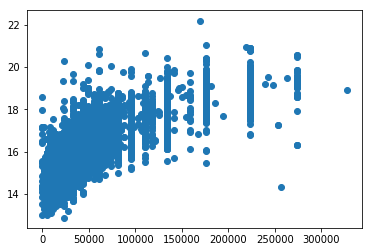

In [286]:
train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["parking_price"], train_Y)

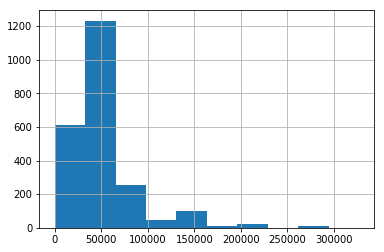

In [287]:
Test_data["parking_price"].hist()

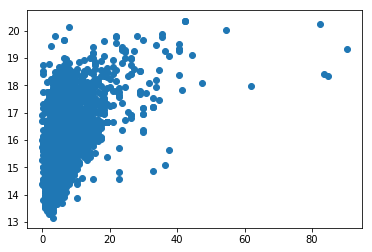

In [288]:
Train_data.sort_values(by = 'parking_area', ascending = False)[:2]
Train_data = Train_data.drop(38617)
Train_data = Train_data.drop(41914)

train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data
plt.scatter(train_X["parking_area"], train_Y)

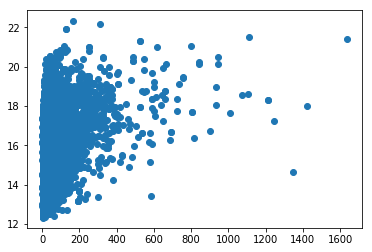

In [289]:
Train_data.sort_values(by = 'land_area', ascending = False)[:10]
Train_data = Train_data.drop(10670)
Train_data = Train_data.drop(41331)
Train_data = Train_data.drop(39191)
Train_data = Train_data.drop(53966)
Train_data = Train_data.drop(7814)
Train_data = Train_data.drop(13332)
Train_data = Train_data.drop(9785)
Train_data = Train_data.drop(14007)
Train_data = Train_data.drop(50076)
Train_data = Train_data.drop(2086)

train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["land_area"], train_Y)

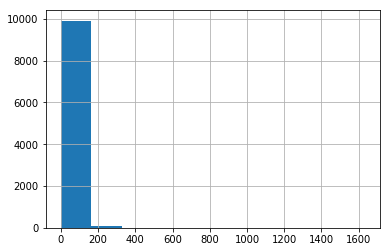

In [290]:
#Test_data["land_area"] = Test_data["land_area"].clip(0, Train_data["land_area"].max())

Test_data["land_area"].clip(0, Train_data["land_area"].max()).hist()

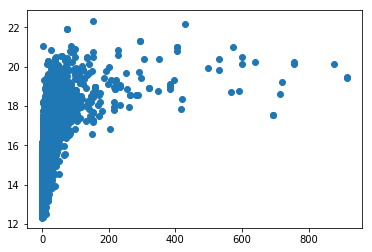

In [291]:
Train_data.sort_values(by = 'building_area', ascending = False)[:20]
Train_data = Train_data.drop(9491)
Train_data = Train_data.drop(46934)

train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["building_area"], train_Y)

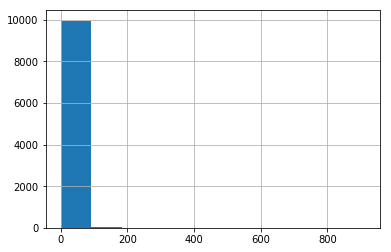

In [292]:
#Test_data["building_area"] = Test_data["building_area"].clip(0, Train_data["building_area"].max())

Test_data["building_area"].clip(0, Train_data["building_area"].max()).hist()

In [293]:
Train_data = Train_data.drop(['total_price'] , axis=1)

#Train_data = Train_data.drop(['parking_area'] , axis=1)
#Test_data = Test_data.drop(['parking_area'] , axis=1)

In [294]:
df = pd.concat([Train_data,Test_data])
df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,NaN,NaN,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,NaN,NaN,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,NaN,NaN,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,NaN,81138.889762,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,NaN,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [295]:
def house_type(row):
    if row == 0:
        return 0
    else:
        return 1
    
df['txn_floor'] = df['txn_floor'].fillna(0)
    
df["house_type"] = df['txn_floor'].apply(house_type)

In [296]:
df["house_type"].value_counts()

1    51451
0    18531
Name: house_type, dtype: int64

In [297]:
parking_price = df['parking_price']
parking_area = df['parking_area']

df = df.drop(['parking_price'] , axis=1)
df = df.drop(['parking_area'] , axis=1)

df = df.fillna(df.mean())
df['parking_price'] = parking_price
df['parking_area'] = parking_area

In [298]:
park_not_null = df[df['parking_price'].notnull()]
park_is_null = df[df['parking_price'].isnull()].drop(['parking_price'] , axis=1)

park_X = park_not_null.drop(['parking_price'] , axis=1)
park_Y = np.log1p(park_not_null['parking_price'])

In [299]:
XGB = xgb.XGBRegressor()
XGB.fit(park_X, park_Y)

park_pred = XGB.predict(park_is_null)
df.loc[df['parking_price'].notnull(), 'parking_price'] = np.log1p(park_not_null['parking_price'])
df.loc[df['parking_price'].isnull(), 'parking_price'] = park_pred

df.head()

/home/rex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,house_type,parking_price
0,8,21,18674,4,3,2,6271,2,3.0,18.144460,...,1,157,1,2483,1,6011,1,34.469803,1,5.730034
1,8,7,18800,5,1,2,7885,2,5.0,11.387227,...,1,115,1,15872,1,32221,1,40.073573,1,10.124750
2,8,7,19289,4,1,2,6028,2,1.0,21.426802,...,1,212,1,15760,1,32228,1,54.462081,1,10.436944
3,8,21,20385,24,0,2,18325,0,13.0,11.387227,...,1,125,1,2568,1,7271,1,99.628966,1,11.303930
4,1,21,20657,2,4,2,6880,2,0.0,61.306524,...,1,47,1,2587,1,7442,1,124.131236,0,8.338449


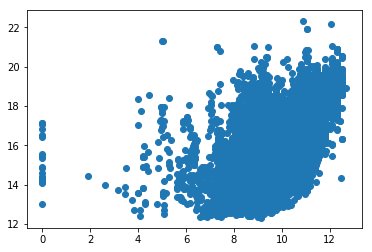

In [300]:
plt.scatter(df[:train_num]["parking_price"], train_Y)

In [302]:
park_area_not_null = df[df['parking_area'].notnull()]
park_area_is_null = df[df['parking_area'].isnull()].drop(['parking_area'] , axis=1)

park_area_X = park_area_not_null.drop(['parking_area'] , axis=1)
park_area_Y = park_area_not_null['parking_area']

XGBR = xgb.XGBRegressor()
XGBR.fit(park_area_X, park_area_Y)

park_area_pred = XGBR.predict(park_area_is_null)

df.loc[df['parking_area'].isnull(), 'parking_area'] = park_area_pred

df.head()

/home/rex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,house_type,parking_price,parking_area
0,8,21,18674,4,3,2,6271,2,3.0,18.144460,...,157,1,2483,1,6011,1,34.469803,1,5.730034,4.089024
1,8,7,18800,5,1,2,7885,2,5.0,11.387227,...,115,1,15872,1,32221,1,40.073573,1,10.124750,2.740472
2,8,7,19289,4,1,2,6028,2,1.0,21.426802,...,212,1,15760,1,32228,1,54.462081,1,10.436944,2.096388
3,8,21,20385,24,0,2,18325,0,13.0,11.387227,...,125,1,2568,1,7271,1,99.628966,1,11.303930,4.504494
4,1,21,20657,2,4,2,6880,2,0.0,61.306524,...,47,1,2587,1,7442,1,124.131236,0,8.338449,4.196989


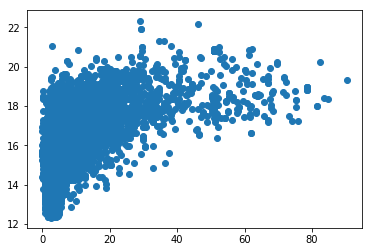

In [303]:
plt.scatter(df[:train_num]["parking_area"], train_Y)

In [304]:
temp_df = copy.deepcopy(df)

In [305]:
temp_df = temp_df.fillna(temp_df.mean())

temp_df["parking_price"] = temp_df["parking_price"].clip(0.1, temp_df["parking_price"].max())
temp_df["parking_area"] = temp_df["parking_area"].clip(0.1, temp_df["parking_area"].max())

temp_df["txn_dt"] = temp_df["txn_dt"]/100
temp_df["building_complete_dt"] = temp_df["building_complete_dt"]/100

temp_df["village_income_median"] = np.log1p(temp_df["village_income_median"])

temp_df["town_area"] = temp_df["town_area"].clip(1, 150)

temp_df["total_building_area"] = temp_df["building_area"] * temp_df["total_floor"]
temp_df["total_income"] = np.log1p(temp_df["village_income_median"] * temp_df["town_population"])
temp_df["area_percent"] = temp_df["land_area"] / temp_df["town_area"]
temp_df["per_parking_price"] = np.log1p(np.expm1(temp_df["parking_price"]) / temp_df["parking_area"])

temp_df["area_diff"] = temp_df["land_area"] - temp_df["building_area"]
temp_df['area_type'] = temp_df['area_diff'].apply(area_type)
#temp_df = temp_df.drop(['area_diff'] , axis=1)

temp_df = temp_df.fillna(temp_df.mean())

train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

In [306]:
temp_df = temp_df.drop(['doc_rate', 'master_rate', 'jobschool_rate', 'highschool_rate'] , axis=1)
temp_df = temp_df.drop(['XIII_5000'] , axis=1)

temp_df = temp_df.drop(['town'] , axis=1)
temp_df = temp_df.drop(['village'] , axis=1)

In [307]:
data = pd.concat([temp_df[:train_num], train_Y], axis=1)
test_data = temp_df[train_num:]

temp_df["txn_floor"] = temp_df["txn_floor"].astype('int')

cols = ["city", "building_type", "building_use", "total_floor", "txn_floor"]

for c in cols:
    
    mean_df = data.groupby([c])['total_price'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    
    data = pd.merge(data, mean_df, on= c, how='left')
    data = data.drop([c] , axis=1)
    
    test_data = pd.merge(test_data, mean_df, on= c, how='left')   
    test_data = test_data.drop([c] , axis=1)
    
data = data.drop(['total_price'] , axis=1)

In [308]:
temp_df = pd.concat([data,test_data])
temp_df.head()

,building_material,txn_dt,building_complete_dt,parking_way,land_area,building_area,lat,lon,village_income_median,town_population,...,total_income,area_percent,per_parking_price,area_diff,area_type,city_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,8,186.74,62.71,2,18.144460,3.418175,-39.14,117.08,6.350886,24219.0,...,11.943494,12.812980,4.331708,14.726285,1,14.761401,15.617864,15.49522,15.607523,15.427335
1,8,188.00,78.85,2,11.387227,4.041309,-37.66,119.28,6.311735,551480.0,...,15.062772,0.492159,9.116689,7.345919,1,15.732706,15.368477,15.49522,15.398017,15.359153
2,8,192.89,60.28,2,21.426802,5.584279,-37.67,119.29,6.439350,551480.0,...,15.082789,0.926072,9.696761,15.842523,1,15.732706,15.368477,15.49522,15.607523,15.784832
3,8,203.85,183.25,0,11.387227,13.563031,-39.13,117.09,6.857514,139259.0,...,13.769437,0.771895,9.798898,-2.175803,0,14.761401,15.837045,15.49522,16.127585,15.832799
4,1,206.57,68.80,2,61.306524,4.688108,-39.24,117.19,6.285998,112397.0,...,13.468119,0.862986,6.904846,56.618416,1,14.761401,15.426263,15.49522,14.951800,15.426263


In [309]:
train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

In [155]:
estimator = xgb.XGBRegressor()
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=train_X.columns)
feats = feats.sort_values(ascending=False)

In [310]:
est = RandomForestRegressor()
est.fit(train_X, train_Y)
feats_est = pd.Series(data=est.feature_importances_, index=train_X.columns)
feats_est = feats_est.sort_values(ascending=False)

/home/rex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [321]:
index_features = []

for f in feats_est[feats_est!=0].index:
    if ("index" in f) and ("50" in f) and ("500" not in f):
        index_features.append(f)

In [200]:
high_feature = list(set(feats[feats!=0].index)&set(feats_est[feats_est!=0].index))

In [322]:
high_feature = list(feats_est[feats_est!=0].index)

In [323]:
high_feature

['building_area',
 'parking_price',
 'XIII_10000',
 'building_complete_dt',
 'land_area',
 'txn_dt',
 'area_diff',
 'V_10000',
 'total_building_area',
 'city_mean',
 'village_income_median',
 'X_5000',
 'bachelor_rate',
 'lon',
 'divorce_rate',
 'VII_1000',
 'area_percent',
 'txn_floor_mean',
 'building_type_mean',
 'VII_5000',
 'elementary_rate',
 'junior_rate',
 'II_5000',
 'VII_10000',
 'per_parking_price',
 'house_type',
 'VII_500',
 'XII_5000',
 'lat',
 'IX_10000',
 'VI_10000',
 'total_income',
 'XIV_10000',
 'parking_area',
 'XII_1000',
 'XI_1000',
 'XIV_5000',
 'IX_1000',
 'X_1000',
 'I_10000',
 'death_rate',
 'V_5000',
 'II_1000',
 'V_500',
 'VIII_500',
 'VI_5000',
 'IV_MIN',
 'X_MIN',
 'XII_10000',
 'IX_MIN',
 'XI_10000',
 'XII_500',
 'XI_5000',
 'XII_MIN',
 'XIV_1000',
 'XI_MIN',
 'parking_way',
 'VIII_MIN',
 'VIII_1000',
 'VI_MIN',
 'III_MIN',
 'XIV_MIN',
 'I_MIN',
 'VII_MIN',
 'town_population_density',
 'XIII_MIN',
 'IV_10000',
 'I_5000',
 'IX_5000',
 'XIV_500',
 'II_MIN',

In [313]:
head = ["II", "III", "IX", "N"]
remove = []

for f in high_feature:
    #if ("0" in f) and (f.split("_")[1] != "10000") and (f.split("_")[0] not in head):
    if ("0" in f) and (f.split("_")[1] != "10000"):
        remove.append(f)
        
for f in remove:
    high_feature.remove(f)

In [314]:
for f in high_feature:
    if "index" in f:
        high_feature.remove(f)

In [315]:
high_feature = high_feature + index_features

In [316]:
high_feature

['building_area',
 'parking_price',
 'XIII_10000',
 'building_complete_dt',
 'land_area',
 'txn_dt',
 'area_diff',
 'V_10000',
 'total_building_area',
 'city_mean',
 'village_income_median',
 'bachelor_rate',
 'lon',
 'divorce_rate',
 'area_percent',
 'txn_floor_mean',
 'building_type_mean',
 'elementary_rate',
 'junior_rate',
 'VII_10000',
 'per_parking_price',
 'house_type',
 'lat',
 'IX_10000',
 'VI_10000',
 'total_income',
 'XIV_10000',
 'parking_area',
 'I_10000',
 'death_rate',
 'IV_MIN',
 'X_MIN',
 'XII_10000',
 'IX_MIN',
 'XI_10000',
 'XII_MIN',
 'XI_MIN',
 'parking_way',
 'VIII_MIN',
 'VI_MIN',
 'III_MIN',
 'XIV_MIN',
 'I_MIN',
 'VII_MIN',
 'town_population_density',
 'XIII_MIN',
 'IV_10000',
 'II_MIN',
 'total_floor_mean',
 'V_MIN',
 'X_10000',
 'town_area',
 'marriage_rate',
 'II_10000',
 'III_10000',
 'town_population',
 'born_rate',
 'VIII_10000',
 'building_use_mean',
 'building_material',
 'area_type',
 'N_10000',
 'II_index_50',
 'VII_index_50',
 'V_index_50',
 'XIV_ind

In [317]:
train_X = train_X[high_feature]
test_X = test_X[high_feature]

In [318]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=4)

estimator_ = RandomForestRegressor()
estimator_.fit(x_train, y_train)

print(cross_val_score(estimator_, x_train, y_train, cv=5).mean())

y_pred = estimator_.predict(x_test)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))

/home/rex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9393690899528823
Mean squared error: 0.0763


In [320]:
estimator_ = RandomForestRegressor(random_state=7)
estimator_.fit(train_X, train_Y)

predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price
submit.to_csv("2019-07-04.csv",index=False)

/home/rex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
